In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LinearRegression
# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.Template import Template
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [2]:
use_resid = False

if use_resid:
    # Load the residuals
    dataset_filename = '..\datasets\power_transitions_with_residuals.xlsx'
else:
    dataset_filename = '..\datasets\power_transitions.xlsx'

dataset_PT = TSD(file_path=dataset_filename)
dataset_PT.raw = dataset_PT.raw.groupby('dataset').get_group('PT')
dataset_PT.scv = dataset_PT.scv.groupby('dataset').get_group('PT')
dataset_PT.scv_imputed = dataset_PT.scv_imputed.groupby('dataset').get_group('PT')

dataset_FULL = TSD(file_path=dataset_filename)
dataset = TSD(file_path=dataset_filename)
dataset.raw = dataset.raw.groupby('dataset').get_group('100y')
dataset.scv = dataset.scv.groupby('dataset').get_group('100y')
dataset.scv_imputed = dataset.scv_imputed.groupby('dataset').get_group('100y')


Dataset loaded from ..\datasets\power_transitions.xlsx
Dataset loaded from ..\datasets\power_transitions.xlsx
Dataset loaded from ..\datasets\power_transitions.xlsx


In [3]:
template = Template(categories=["sc","wf","rt"], file_path="../datasets/template.csv")
template.add_dataset_from_url("human-sacrifices","https://seshat-db.com/api/rt/human-sacrifices/")
template.save_dataset("../datasets/template.csv")
dataset.template = template
dataset.add_column("https://seshat-db.com/api/rt/human-sacrifices")

Loaded template from ../datasets/template.csv
Dataset human-sacrifices already in dataframe
Saved template to ../datasets/template.csv
Error: The year -400.0 is outside the polity years [-330.0, -312.0]
Error: The year 600.0 is outside the polity years [632.0, 661.0]
Error: The year 1800.0 is outside the polity years [1820.0, 1898.0]


In [4]:
polaris_filename = "..\datasets\Polaris_data.xlsx"
religion_df = pd.read_excel(polaris_filename, sheet_name='Religion')

dataset.scv['religion'] = dataset.scv.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].religion.values[0] if x in religion_df.PolID.values else np.nan)
dataset.scv_imputed['religion'] = dataset.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].religion.values[0] if x in religion_df.PolID.values else np.nan)
dataset.scv['religion_family'] = dataset.scv.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].RelFam.values[0] if x in religion_df.PolID.values else np.nan)
dataset.scv_imputed['religion_family'] = dataset.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].RelFam.values[0] if x in religion_df.PolID.values else np.nan)
dataset.scv['MSP'] = dataset.scv.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].MSP_imp.values[0] if x in religion_df.PolID.values else np.nan)
dataset.scv_imputed['MSP'] = dataset.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].MSP_imp.values[0] if x in religion_df.PolID.values else np.nan)

In [5]:
crisis_vars = ['overturn',
              'predecessor_assassination'
              ,'intra_elite'
              ,'military_revolt'
              ,'popular_uprising'
              ,'separatist_rebellion'
              ,'external_invasion'
              ,'external_interference'
              ]

pt_dat = dataset_PT.raw[['PolityID', 'PolityName','Year']+crisis_vars].copy()


In [6]:
dt = 100
for col in crisis_vars:
    dataset.scv_imputed[col] = np.nan
dataset.scv_imputed['peaceful_transition'] = np.nan
for i, row in dataset.scv_imputed.iterrows():
    # find entries in pt dataset that match the country and year
    match = pt_dat[(pt_dat['PolityID'] == row['PolityID']) & (pt_dat['Year'] >= row['Year'])& (pt_dat['Year'] < row['Year']+dt)]
    if len(match) == 0:
        continue
    for col in crisis_vars:
        if match[col].dropna().sum() > 0:
            dataset.scv_imputed.at[i, col] = match[col].dropna().mean()
    dataset.scv_imputed.at[i, 'peaceful_transition'] = len(match[match[crisis_vars].sum(axis=1) == 0]) / len(match)
    
crisis_vars.append('peaceful_transition')

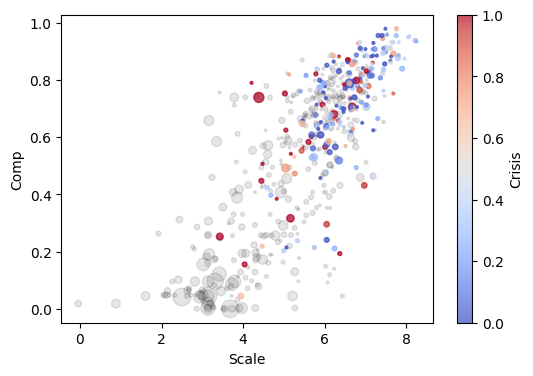

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4))

gray_plot = dataset.scv_imputed[pd.isna(dataset.scv_imputed['predecessor_assassination'])]
gray_group = gray_plot.groupby('PolityName')
mean_inst_1 = gray_group['Comp'].mean()
mean_scale_1 = gray_group['Scale_1'].mean()
num_observations = gray_group.size()
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      c = 'black',
                      s=num_observations * 4,
                      alpha=0.1,
                      )

dataset_plot = dataset.scv_imputed.dropna(subset = ['Comp', 'Scale_1', 'predecessor_assassination'])
polity_group = dataset.scv_imputed.groupby('PolityName')

# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['peaceful_transition'].mean()
num_observations = polity_group.size()


v_max = mean_crisis.max()*1
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 4,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.show()

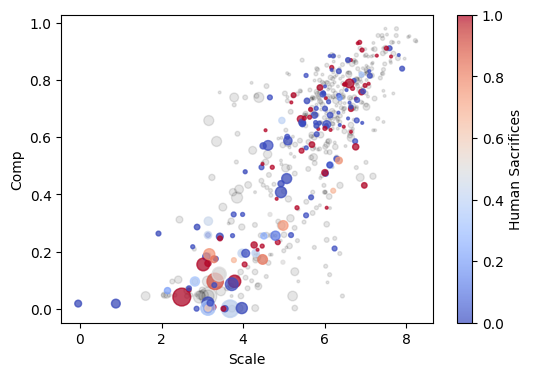

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4))

gray_plot = dataset.scv_imputed
gray_plot["human_sacrifices"] = dataset.raw['human-sacrifices']
gray_plot = gray_plot[pd.isna(gray_plot['human_sacrifices'])]
gray_group = gray_plot.groupby('PolityName')
mean_inst_1 = gray_group['Comp'].mean()
mean_scale_1 = gray_group['Scale_1'].mean()
num_observations = gray_group.size()
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      c = 'black',
                      s=num_observations * 4,
                      alpha=0.1,
                      )


dataset_plot = dataset.scv_imputed
dataset_plot["human_sacrifices"] = dataset.raw['human-sacrifices']
dataset_plot = dataset_plot.dropna(subset = ['Comp', 'Scale_1', 'human_sacrifices'])
polity_group = dataset.scv_imputed.groupby('PolityName')

# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['human_sacrifices'].mean()
num_observations = polity_group.size()


v_max = mean_crisis.max()
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 4,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Human Sacrifices')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.show()

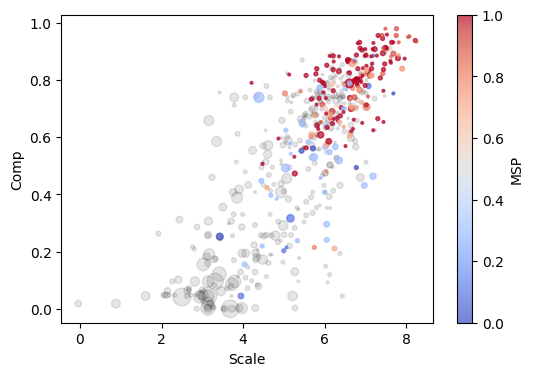

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4))

gray_plot = dataset.scv_imputed
gray_plot = gray_plot[pd.isna(gray_plot['MSP'])]
gray_group = gray_plot.groupby('PolityName')
mean_inst_1 = gray_group['Comp'].mean()
mean_scale_1 = gray_group['Scale_1'].mean()
num_observations = gray_group.size()
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      c = 'black',
                      s=num_observations * 4,
                      alpha=0.1,
                      )


dataset_plot = dataset.scv_imputed
dataset_plot = dataset_plot.dropna(subset = ['Comp', 'Scale_1', 'MSP'])
polity_group = dataset_plot.groupby('PolityName')

# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['MSP'].mean()
num_observations = polity_group.size()


v_max = mean_crisis.max()
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 4,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='MSP')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.show()

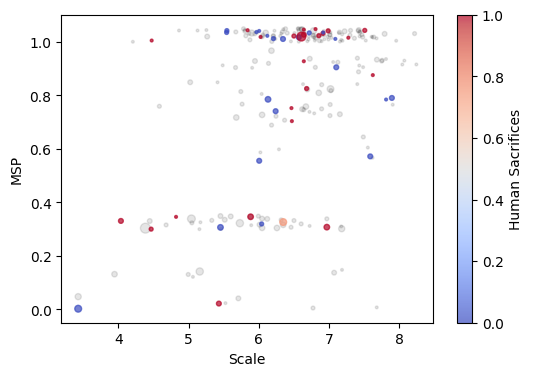

In [10]:
import matplotlib.pyplot as plt
import random
fig, ax = plt.subplots(figsize=(6, 4))

gray_plot = dataset.scv_imputed
gray_plot["human_sacrifices"] = dataset.raw['human-sacrifices']
gray_plot = gray_plot[pd.isna(gray_plot['human_sacrifices'])]
gray_group = gray_plot.groupby('PolityName')
mean_inst_1 = gray_group['MSP'].mean().apply(lambda x: x + 0.05*random.random())
mean_scale_1 = gray_group['Scale_1'].mean()
num_observations = gray_group.size()
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      c = 'black',
                      s=num_observations * 4,
                      alpha=0.1,
                      )


dataset_plot = dataset.scv_imputed
dataset_plot["human_sacrifices"] = dataset.raw['human-sacrifices']
dataset_plot = dataset_plot.dropna(subset = ['MSP', 'Scale_1', 'human_sacrifices'])
polity_group = dataset.scv_imputed.groupby('PolityName')

# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['MSP'].mean().apply(lambda x: x + 0.05*random.random())
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['human_sacrifices'].mean()
num_observations = polity_group.size()


v_max = mean_crisis.max()
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 4,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Human Sacrifices')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('MSP')
plt.xlabel('Scale')
plt.show()

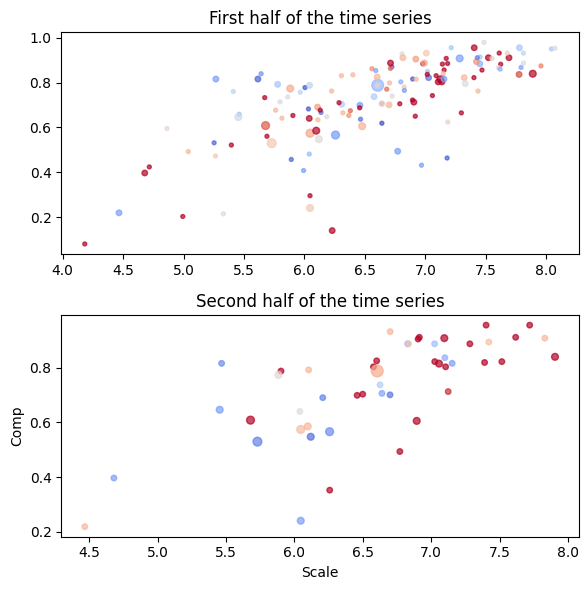

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,figsize=(6, 6))

dataset_plot = dataset.scv_imputed.dropna(subset = ['Comp', 'Scale_1', 'predecessor_assassination'])
polity_group = dataset_plot.groupby('PolityName')

# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].apply(lambda x: np.mean(x[:int(np.ceil(len(x)/2))]))
mean_scale_1 = polity_group['Scale_1'].apply(lambda x: np.mean(x[:int(np.ceil(len(x)/2))]))
mean_crisis = polity_group['predecessor_assassination'].apply(lambda x: np.mean(x[:int(np.ceil(len(x)/2))]))
num_observations = polity_group.size()


v_max = mean_crisis.max()*0.5
# Create a scatter plot
scatter = ax[0].scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 8,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )
ax[0].set_title('First half of the time series')
# Add a color bar
# ax[0].colorbar(scatter, label='Crisis')
# add name of polity on each bubble
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].apply(lambda x: np.mean(x[int(np.ceil(len(x)/2)):]))
mean_scale_1 = polity_group['Scale_1'].apply(lambda x: np.mean(x[int(np.ceil(len(x)/2)):]))
mean_crisis = polity_group['predecessor_assassination'].apply(lambda x: np.mean(x[int(np.ceil(len(x)/2)):]))
num_observations = polity_group.size()


v_max = mean_crisis.max()*0.5
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 8,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
ax[1].set_title('Second half of the time series')
# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.tight_layout()
plt.show()

In [12]:
test_cols = dataset.raw.columns[14:]
def get_correlation(col1, col2):
    """
    Calculate the correlation between two columns in a DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data.
        col1 (str): Name of the first column.
        col2 (str): Name of the second column.
    
    Returns:
        float: Correlation coefficient between the two columns.
    """
    return col1.corr(col2)

C:\Users\matil\AppData\Local\Temp\ipykernel_1236\771928568.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('coolwarm', len(correlations[:, 0]))


<BarContainer object of 108 artists>

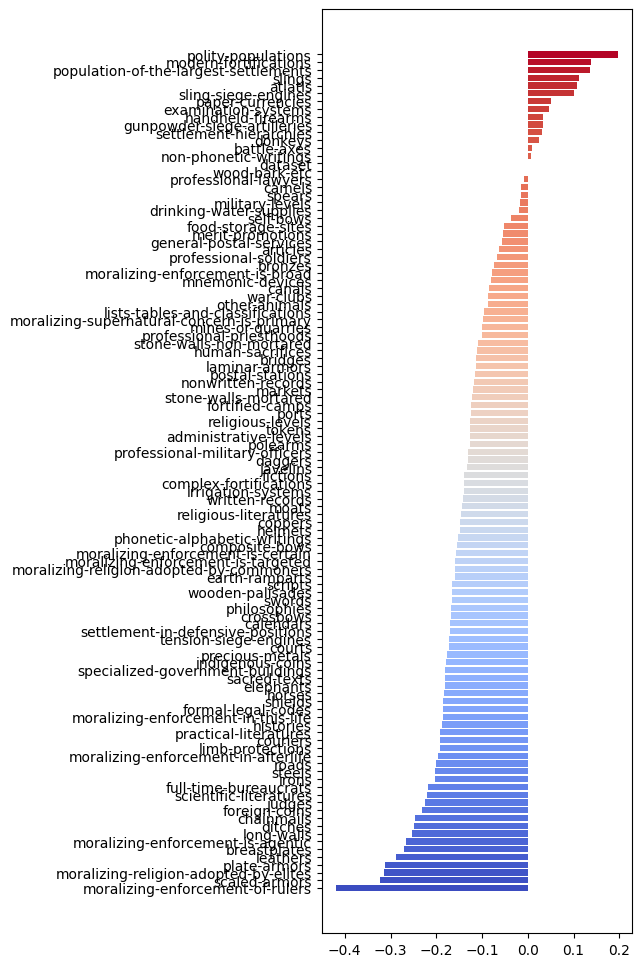

In [13]:
correlations = np.zeros((len(test_cols), len(crisis_vars)))
for col in test_cols:
    for crisis in crisis_vars:
        if (col not in dataset.raw.columns) or (col in ['dataset']):
            continue
        correlation = get_correlation(dataset.raw[col], dataset.scv_imputed[crisis])
        correlations[test_cols.tolist().index(col), crisis_vars.index(crisis)] = correlation


plt.figure(figsize=(4, 12))
colormap = plt.cm.get_cmap('coolwarm', len(correlations[:, 0]))
sorted_indices = np.argsort(correlations[:, 0])

# plt.title('Correlation of MSP Features with Human Sacrifice')
plt.barh(test_cols[sorted_indices], correlations[sorted_indices,0], color=colormap(np.linspace(0, 1, len(correlations))))
# plt.xlabel('Correlation with Human Sacrifice')

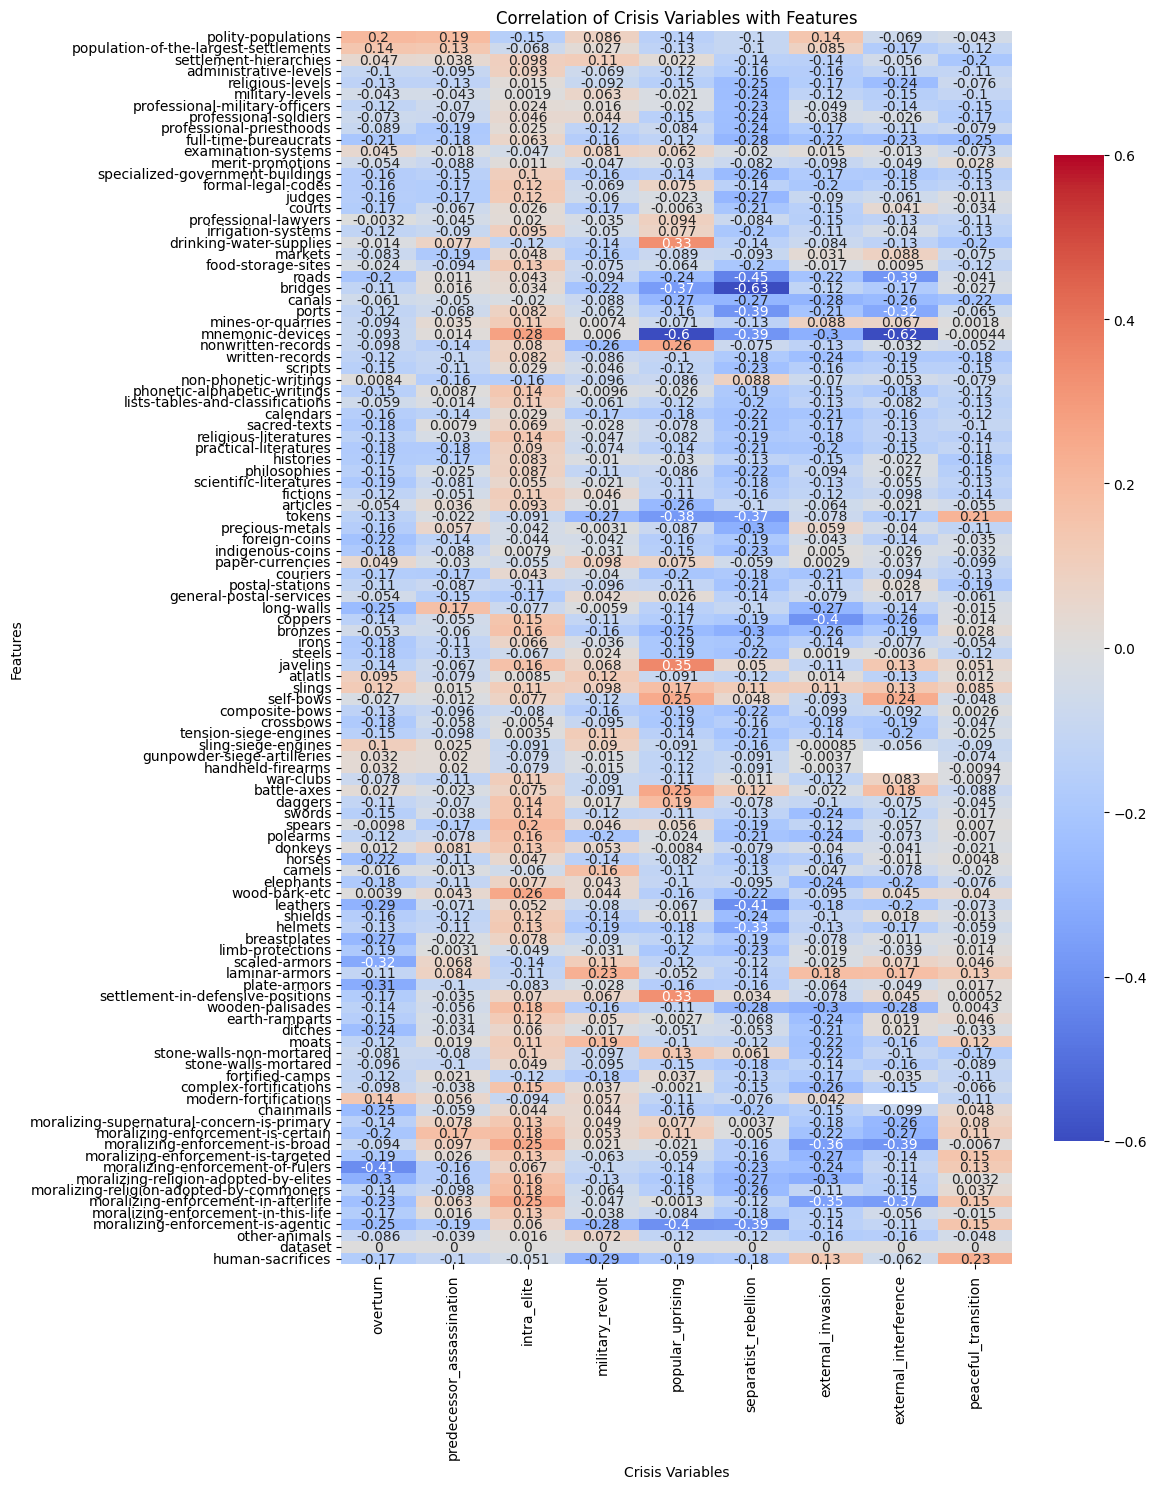

In [103]:
import seaborn as sns
plt.figure(figsize=(12, 15))
sns.heatmap(correlations, annot=True, cmap='coolwarm', xticklabels=crisis_vars, yticklabels=test_cols,
            vmin= -0.6, vmax=0.6, center=0, cbar_kws={"shrink": 0.8})

plt.title('Correlation of Crisis Variables with Features')
plt.xlabel('Crisis Variables')
plt.ylabel('Features')
plt.tight_layout()

plt.show()

In [104]:
regression_results = pd.DataFrame(columns=['feature', 'crisis', 'coeff', 'p_value', 'r2', 'n'])
for col in test_cols:
    if col not in dataset.raw.columns or col in ['dataset']:
        continue
    for crisis in crisis_vars:
        x_cols = dataset.raw[col]
        y_col = dataset.scv_imputed[crisis]
        Xy = pd.concat([x_cols, y_col], axis=1).dropna()

        Xy['intercept'] = 1
        if col in test_cols[6:]:
            pd.get_dummies(Xy[col], drop_first=True)
            X = Xy.drop(columns=[crisis]).round()
            y = Xy[crisis]

            model = sm.OLS(y, X)
            result = model.fit()
            p_vals = result.pvalues
            r2 = result.rsquared
            coeff = result.params[col]
        else:

            X = Xy.drop(columns=[crisis])
            y = Xy[crisis]

            model = sm.OLS(y, X)
            result = model.fit()
            p_vals = result.pvalues
            r2 = result.rsquared
            coeff = result.params[col]


        row = pd.DataFrame({'feature': col, 'crisis': crisis, 'coeff': coeff,'p_value': p_vals[0], 'r2': r2, 'n': len(Xy)}, index=[0])
        regression_results = pd.concat([regression_results, row], ignore_index=True)

In [105]:
for crisis in crisis_vars:

    regression_results.sort_values(by='r2', inplace=True, ascending=False)
    display(regression_results[regression_results.crisis == crisis].head(5))


,feature,crisis,coeff,p_value,r2,n
891,moralizing-enforcement-of-rulers,overturn,-0.285130,0.001854,0.171464,54
729,scaled-armors,overturn,-0.396944,0.006878,0.104016,69
747,plate-armors,overturn,-0.328039,0.006139,0.098381,75
900,moralizing-religion-adopted-by-elites,overturn,-0.209358,0.049562,0.088720,44
684,leathers,overturn,-0.224597,0.066754,0.083585,41


,feature,crisis,coeff,p_value,r2,n
73,professional-priesthoods,predecessor_assassination,-1.147658e-01,0.104590,0.036169,74
172,markets,predecessor_assassination,-1.203844e-01,0.074061,0.035021,92
1,polity-populations,predecessor_assassination,7.991287e-10,0.200850,0.034572,49
937,moralizing-enforcement-is-agentic,predecessor_assassination,-1.046285e-01,0.214135,0.031965,50
82,full-time-bureaucrats,predecessor_assassination,-1.026384e-01,0.095989,0.031888,88


,feature,crisis,coeff,p_value,r2,n
236,mnemonic-devices,intra_elite,0.193567,0.146737,0.076368,29
875,moralizing-enforcement-is-broad,intra_elite,0.145894,0.031306,0.071487,65
677,wood-bark-etc,intra_elite,0.158204,0.093787,0.065419,44
920,moralizing-enforcement-in-afterlife,intra_elite,0.127863,0.076265,0.056029,57
623,spears,intra_elite,0.130849,0.053315,0.038742,97


,feature,crisis,coeff,p_value,r2,n
957,human-sacrifices,military_revolt,-0.131635,0.082185,0.083828,37
381,tokens,military_revolt,-0.121420,0.084715,0.070745,43
246,nonwritten-records,military_revolt,-0.151894,0.083729,0.066440,46
741,laminar-armors,military_revolt,0.259698,0.089503,0.052462,56
939,moralizing-enforcement-is-agentic,military_revolt,-0.092106,0.153260,0.049105,43


,feature,crisis,coeff,p_value,r2,n
238,mnemonic-devices,popular_uprising,-0.376658,0.016963,0.365531,15
382,tokens,popular_uprising,-0.151238,0.025230,0.142766,35
202,bridges,popular_uprising,-0.185097,0.044234,0.136817,30
499,javelins,popular_uprising,0.142041,0.017963,0.120768,46
940,moralizing-enforcement-is-agentic,popular_uprising,-0.169473,0.053087,0.111956,34


,feature,crisis,coeff,p_value,r2,n
203,bridges,separatist_rebellion,-0.296568,0.001700,0.396103,22
194,roads,separatist_rebellion,-0.233290,0.000762,0.200951,53
689,leathers,separatist_rebellion,-0.177563,0.063153,0.170125,21
221,ports,separatist_rebellion,-0.152359,0.005133,0.154979,49
239,mnemonic-devices,separatist_rebellion,-0.235660,0.119898,0.153483,17


,feature,crisis,coeff,p_value,r2,n
465,coppers,external_invasion,-0.236449,0.001429,0.157070,62
771,wooden-palisades,external_invasion,-0.201541,0.031921,0.092340,50
906,moralizing-religion-adopted-by-elites,external_invasion,-0.169977,0.098044,0.091544,31
240,mnemonic-devices,external_invasion,-0.198214,0.205887,0.087327,20
924,moralizing-enforcement-in-afterlife,external_invasion,-0.131554,0.088038,0.083179,36


,feature,crisis,coeff,p_value,r2,n
241,mnemonic-devices,external_interference,-0.423076,0.007527,0.388360,17
196,roads,external_interference,-0.272420,0.002671,0.149980,58
223,ports,external_interference,-0.180458,0.020252,0.103157,52
880,moralizing-enforcement-is-broad,external_interference,-0.148434,0.075247,0.090124,36
925,moralizing-enforcement-in-afterlife,external_interference,-0.133604,0.125829,0.081656,30


,feature,crisis,coeff,p_value,r2,n
89,full-time-bureaucrats,peaceful_transition,-0.187374,0.001636,0.062181,157
962,human-sacrifices,peaceful_transition,0.175792,0.044027,0.054399,75
215,canals,peaceful_transition,-0.172122,0.034149,0.049988,90
440,postal-stations,peaceful_transition,-0.244814,0.019858,0.047903,113
386,tokens,peaceful_transition,0.169849,0.048683,0.045473,86
